# **Automatic layer selection**

This notebook is the first in a series of four, in which we conduct a brief study on hallucination detection using a model's own internal representations. The underlying hypothesis is that hallucination-related signals may be encoded in the model's hidden states and can be extracted using a lightweight classical probe (in our case, an XGBoost classifier). We focus on Mistral's [Ministral-8B-Instruct-2410](https://huggingface.co/mistralai/Ministral-8B-Instruct-2410), chosen for its relatively modest size, which facilitates rapid experimentation and activation extraction.

Our dataset, [krogoldAI/hallucination-labeled-dataset](https://huggingface.co/datasets/krogoldAI/hallucination-labeled-dataset), comprises 145,169 labelled examples generated by Ministral-8B-Instruct-2410 at temperature 0.7, with an overall hallucination rate of 32.2%. The data is split 70/15/15 into train, validation, and test sets, with consistent per-dataset distribution and hallucination rate across splits. Notably, we use outputs from the same model on which we perform our probing experiments; this design choice avoids confounding effects that could arise from unusually high perplexity when probing a model on out-of-distribution text.

Before training a probe on one or several activation layers, we must first identify which layers are most "expressive" for hallucination detection. Our approach is as follows: we extract activations from all layers, apply mean-pooling, and train a simple XGBoost probe on each pooled representation. We then rank layers by accuracy and F1 score to identify the most promising candidates - likely mid-to-late layers, though this remains to be confirmed empirically.

Since this constitutes hyperparameter selection, we train these preliminary probes on the validation set and evaluate on the test set. The final probe training, presented in subsequent notebooks, will use the full training set.

*Setup:* Here, and in subsequent notebooks, all training and extraction will be performed on a single NVIDIA A100 SXM GPU.


### 1. Installing required libraries

Before doing so, let's first install the necessary libraries:

In [2]:
# Install `llmscan`
!pip install git+https://github.com/julienbrasseur/llm-hallucination-detector.git

# Install `datasets`
!pip install datasets

  Cloning https://github.com/julienbrasseur/llm-hallucination-detector.git to /tmp/pip-req-build-02urtt2w
  Running command git clone --filter=blob:none --quiet https://github.com/julienbrasseur/llm-hallucination-detector.git /tmp/pip-req-build-02urtt2w
  Resolved https://github.com/julienbrasseur/llm-hallucination-detector.git to commit 77b721d351f3cb5b08d8447d199d6afe38970d26
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 11.8 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 30.7 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 52.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 53.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 79.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 141.8 MB/s  0:00:00 eta 0:00:01
 

### 2. Data preparation

Now, let's load the dataset which we'll use throughout our experiment, and convert it to a standard OpenAI-type format.

In [3]:
import torch
import numpy as np
from datasets import load_dataset

# Set training dataset path
DATASET_NAME = "krogoldAI/hallucination-labeled-dataset"

def load_and_format_dataset(dataset_name: str):
    """
    Load HuggingFace dataset and convert to conversation format.
    
    This function converts dataset with 'input', 'target', 'hallucination' fields
    to the standard conversation format expected by the pipeline.
    
    Returns:
        Tuple of (train_data, val_data, test_data, train_labels, val_labels, test_labels)
    """
    print(f"Loading dataset: {dataset_name}")
    ds = load_dataset(dataset_name)

    # Shuffle each split
    ds["train"] = ds["train"].shuffle(seed=42)
    ds["validation"] = ds["validation"].shuffle(seed=42)
    ds["test"] = ds["test"].shuffle(seed=42)
    
    def format_split(split):
        """Convert HF dataset split to conversation format."""
        formatted = []
        labels = []
        
        for item in split:
            # Extract fields
            user_msg = item["input"]
            assistant_msg = item["target"]
            label = int(item["hallucination"])
            
            # Convert to OpenAI conversation format
            formatted.append({
                "conversation": [
                    {"role": "user", "content": user_msg},
                    {"role": "assistant", "content": assistant_msg},
                ]
            })
            labels.append(label)
        
        return formatted, np.array(labels)
    
    # Format all splits
    train_data, train_labels = format_split(ds["train"])
    val_data, val_labels = format_split(ds["validation"])
    test_data, test_labels = format_split(ds["test"])
    
    print(f"Dataset loaded and formatted:")
    print(f"\tTrain:      {len(train_data):,} examples")
    print(f"\tValidation: {len(val_data):,} examples")
    print(f"\tTest:       {len(test_data):,} examples")
    print(f"\tClass distribution (train): "
          f"{(train_labels == 0).sum():,} non-hallucination, "
          f"{(train_labels == 1).sum():,} hallucination")
    
    return train_data, val_data, test_data, train_labels, val_labels, test_labels

# Load and format dataset
train_data, val_data, test_data, train_labels, val_labels, test_labels = \
    load_and_format_dataset(DATASET_NAME)

Loading dataset: krogoldAI/hallucination-labeled-dataset


README.md:   0%|          | 0.00/58.5k [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/78.7M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/16.7M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/16.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/101618 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21775 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/21776 [00:00<?, ? examples/s]

Dataset loaded and formatted:
	Train:      101,618 examples
	Validation: 21,775 examples
	Test:       21,776 examples
	Class distribution (train): 68,913 non-hallucination, 32,705 hallucination


### 3. Automatic layer evaluation

Finally, let's use the `ActivationExtractor` class and the `layer_selection_pipeline` function to rank layers.

config.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.07G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.


Loaded model mistralai/Ministral-8B-Instruct-2410. Target layers: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]. Device for inputs: cuda
[Extracting val] Computing activations for layers: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]


Extracting: 100%|██████████| 1361/1361 [26:31<00:00,  1.17s/it]


[Extracting test] Computing activations for layers: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]


Evaluating layers:   0%|          | 0/36 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/xgboost/core.py:774: UserWarning: [13:49:20] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
Evaluating layers: 100%|██████████| 36/36 [02:24<00:00,  4.02s/it]



===== Layer Ranking (Best → Worst) =====
Layer 16: F1=0.8220 | Acc=0.8288
Layer 15: F1=0.8212 | Acc=0.8279
Layer 18: F1=0.8211 | Acc=0.8282
Layer 21: F1=0.8206 | Acc=0.8276
Layer 17: F1=0.8205 | Acc=0.8273
Layer 19: F1=0.8197 | Acc=0.8267
Layer 20: F1=0.8178 | Acc=0.8252
Layer 22: F1=0.8159 | Acc=0.8234
Layer 26: F1=0.8146 | Acc=0.8222
Layer 25: F1=0.8146 | Acc=0.8221
Layer 27: F1=0.8140 | Acc=0.8217
Layer 23: F1=0.8136 | Acc=0.8214
Layer 24: F1=0.8136 | Acc=0.8211
Layer 14: F1=0.8122 | Acc=0.8197
Layer 28: F1=0.8120 | Acc=0.8199
Layer 13: F1=0.8116 | Acc=0.8194
Layer 29: F1=0.8110 | Acc=0.8190
Layer 30: F1=0.8095 | Acc=0.8176
Layer 31: F1=0.8087 | Acc=0.8168
Layer 32: F1=0.8054 | Acc=0.8141
Layer 11: F1=0.8038 | Acc=0.8128
Layer 33: F1=0.8034 | Acc=0.8120
Layer 34: F1=0.8013 | Acc=0.8108
Layer 12: F1=0.8002 | Acc=0.8092
Layer 10: F1=0.7976 | Acc=0.8067
Layer 9: F1=0.7969 | Acc=0.8061
Layer 8: F1=0.7908 | Acc=0.8001
Layer 35: F1=0.7904 | Acc=0.8007
Layer 7: F1=0.7886 | Acc=0.7989
Laye

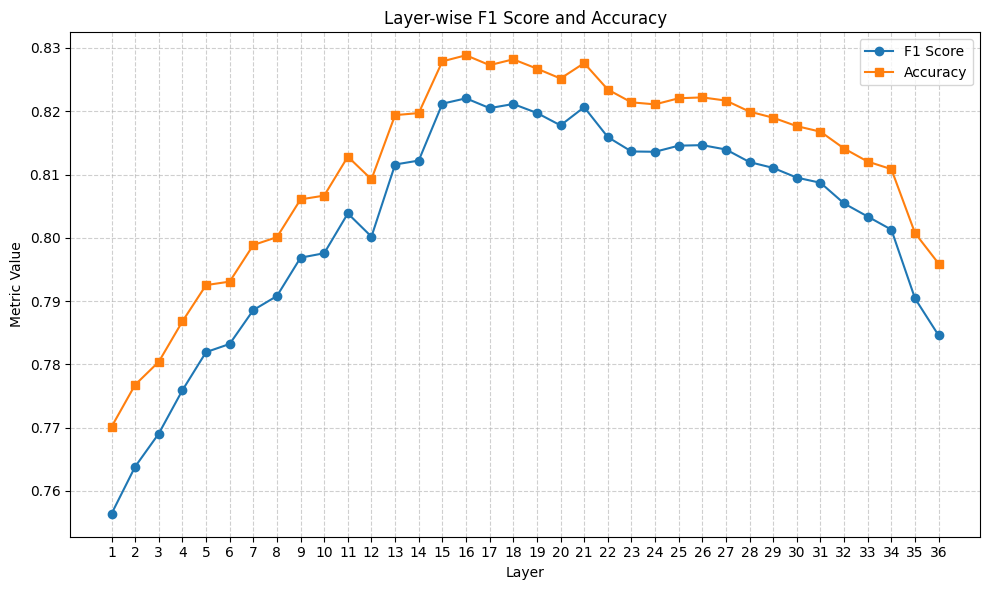

In [4]:
from llmscan import ActivationExtractor, layer_selection_pipeline

# Total layer number
N_LAYERS = 36

extractor = ActivationExtractor(
    model_name="mistralai/Ministral-8B-Instruct-2410",
    target_layers=list(range(1, N_LAYERS + 1)),
    device="cuda"
)

ranked, metrics = layer_selection_pipeline(
    extractor=extractor,
    layers=list(range(1, N_LAYERS + 1)),
    val_data=val_data,
    test_data=test_data,
    labels_val=val_labels,
    labels_test=test_labels,
    batch_size=16,
    focus_on_assistant=True,
    plot_results=True,
    save_path="layer_selection.png"
)

### 4. Comments

This simple analysis revealed that mid-layers are the most expressive ones for our task, particularly layers 16, 15, 18 and 21.

This could be interpreted by saying that:
- Early layers (1-10) focus on syntactic/surface features - so too low-level for hallucination detection
- Late layers (25-36) are highly task-specific and abstract - may be optimized for generation rather than reflection?
- Mid layers (15-21) appear to capture semantic representations where the model maintains factual grounding

*Remark:* As we'll see later on, F1 scores here are not to be taken too literally, though accuracies are a good reflection of what our strategy can achieve.